In [1]:
import sys,os
from pathlib import Path
curr_path = str(Path().absolute())
parent_path = str(Path().absolute().parent)
sys.path.append(parent_path) # add current terminal path to sys.path
import gym
import torch
import datetime
from DQN.agent import DQN
from common.plot import plot_rewards
from common.utils import save_results

In [2]:
SEQUENCE = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # 获取当前时间
SAVED_MODEL_PATH = curr_path+"/saved_model/"+SEQUENCE+'/' # 生成保存的模型路径
if not os.path.exists(curr_path+"/saved_model/"): # 检测是否存在文件夹
    os.mkdir(curr_path+"/saved_model/")
if not os.path.exists(SAVED_MODEL_PATH): # 检测是否存在文件夹
    os.mkdir(SAVED_MODEL_PATH)
RESULT_PATH = curr_path+"/results/"+SEQUENCE+'/' # 存储reward的路径
if not os.path.exists(curr_path+"/results/"): # 检测是否存在文件夹
    os.mkdir(curr_path+"/results/")
if not os.path.exists(RESULT_PATH): # 检测是否存在文件夹
    os.mkdir(RESULT_PATH)

In [3]:
class DQNConfig:
    def __init__(self):
        self.algo = "DQN" # 算法名称
        self.gamma = 0.99
        self.epsilon_start = 0.95 # e-greedy策略的初始epsilon
        self.epsilon_end = 0.01
        self.epsilon_decay = 200
        self.lr = 0.01 # 学习率
        self.memory_capacity = 800 # Replay Memory容量
        self.batch_size = 64
        self.train_eps = 300 # 训练的episode数目
        self.train_steps = 200 # 训练每个episode的最大长度
        self.target_update = 2 # target net的更新频率
        self.eval_eps = 20 # 测试的episode数目
        self.eval_steps = 200 # 测试每个episode的最大长度
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 检测gpu
        self.hidden_dim = 128 # 神经网络隐藏层维度

In [4]:
def train(cfg,env,agent):
    print('Start to train !')
    rewards = []
    ma_rewards = [] # 滑动平均的reward
    ep_steps = []
    for i_episode in range(cfg.train_eps):
        state = env.reset() # reset环境状态
        ep_reward = 0
        for i_step in range(cfg.train_steps):
            action = agent.choose_action(state) # 根据当前环境state选择action
            next_state, reward, done, _ = env.step(action) # 更新环境参数
            ep_reward += reward
            agent.memory.push(state, action, reward, next_state, done) # 将state等这些transition存入memory
            state = next_state # 跳转到下一个状态
            agent.update() # 每步更新网络
            if done:
                break
        # 更新target network，复制DQN中的所有weights and biases
        if i_episode % cfg.target_update == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
        print('Episode:{}/{}, Reward:{}, Steps:{}, Done:{}'.format(i_episode+1,cfg.train_eps,ep_reward,i_step+1,done))
        ep_steps.append(i_step)
        rewards.append(ep_reward)
        # 计算滑动窗口的reward
        if ma_rewards:
            ma_rewards.append(
                0.9*ma_rewards[-1]+0.1*ep_reward)
        else:
            ma_rewards.append(ep_reward)   
    print('Complete training！')
    return rewards,ma_rewards

Start to train !
Episode:1/300, Reward:41.0, Steps:41, Done:True
Episode:2/300, Reward:23.0, Steps:23, Done:True
Episode:3/300, Reward:19.0, Steps:19, Done:True
Episode:4/300, Reward:17.0, Steps:17, Done:True
Episode:5/300, Reward:14.0, Steps:14, Done:True
Episode:6/300, Reward:15.0, Steps:15, Done:True
Episode:7/300, Reward:10.0, Steps:10, Done:True
Episode:8/300, Reward:23.0, Steps:23, Done:True
Episode:9/300, Reward:14.0, Steps:14, Done:True
Episode:10/300, Reward:9.0, Steps:9, Done:True
Episode:11/300, Reward:9.0, Steps:9, Done:True
Episode:12/300, Reward:9.0, Steps:9, Done:True
Episode:13/300, Reward:9.0, Steps:9, Done:True
Episode:14/300, Reward:10.0, Steps:10, Done:True
Episode:15/300, Reward:10.0, Steps:10, Done:True
Episode:16/300, Reward:12.0, Steps:12, Done:True
Episode:17/300, Reward:10.0, Steps:10, Done:True
Episode:18/300, Reward:10.0, Steps:10, Done:True
Episode:19/300, Reward:9.0, Steps:9, Done:True
Episode:20/300, Reward:10.0, Steps:10, Done:True
Episode:21/300, Reward

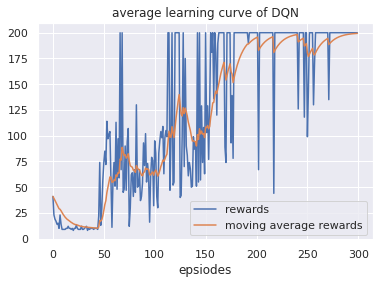

In [5]:
cfg = DQNConfig()
env = gym.make('CartPole-v0')
env.seed(1)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = DQN(state_dim,action_dim,cfg)
rewards,ma_rewards = train(cfg,env,agent)
agent.save(path=SAVED_MODEL_PATH)
save_results(rewards,ma_rewards,tag='train',path=RESULT_PATH)
plot_rewards(rewards,ma_rewards,tag="train",algo = cfg.algo,path=RESULT_PATH)